# MNIST Classification with TensorFlow (Fully Connected Network and CNN)

This notebook implements **two neural networks** using TensorFlow/Keras for the MNIST digit classification task:

1. A **fully connected (dense) neural network** with architecture `784 → 512 → 512 → 10` using ReLU activations and a final Softmax.
2. A **convolutional neural network (CNN)** following the block structure:  
   `Input → Convolution → Max Pooling → Convolution → Dropout → Max Pooling → Convolution → Max Pooling → Linear → Linear → Output`

For **each network** we will:

- Load and preprocess the MNIST data.
- Define the model architecture in TensorFlow.
- Specify the **loss function**, **optimizer**, and **metrics**.
- Implement an explicit **training loop** using `tf.GradientTape`.
- Track **training and validation loss and accuracy per epoch** and plot them.
- Run a **prediction example** on a test image and visualize both the image and the predicted probabilities.


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Make sure we're using TensorFlow 2.x in eager mode
print("TensorFlow version:", tf.__version__)

# 1. Load and preprocess MNIST

# MNIST has 60,000 training and 10,000 test images of size 28x28 (grayscale).
# Keras will automatically download it the first time you call this.
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

print("Original training set shape:", x_train_full.shape, y_train_full.shape)
print("Original test set shape:", x_test.shape, y_test.shape)

# Normalize images to [0, 1] by dividing by 255.0
x_train_full = x_train_full.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Create a validation split from training
# We'll use 50,000 images for training and 10,000 for validation.
x_train, x_val = x_train_full[:50000], x_train_full[50000:]
y_train, y_val = y_train_full[:50000], y_train_full[50000:]

print("Training set:", x_train.shape, y_train.shape)
print("Validation set:", x_val.shape, y_val.shape)
print("Test set:", x_test.shape, y_test.shape)

# Prepare data for the fully connected network
# Flatten images to vectors of length 784 = 28*28
x_train_flat = x_train.reshape(-1, 28 * 28)
x_val_flat = x_val.reshape(-1, 28 * 28)
x_test_flat = x_test.reshape(-1, 28 * 28)

print("Flattened training set shape:", x_train_flat.shape)

# Prepare data for the CNN
# Add a channel dimension to each image so the shape is (28, 28, 1)
x_train_cnn = x_train[..., tf.newaxis]
x_val_cnn = x_val[..., tf.newaxis]
x_test_cnn = x_test[..., tf.newaxis]

print("CNN training data shape:", x_train_cnn.shape)

# Build tf.data.Datasets for efficient iteration

batch_size = 128

# Datasets for fully connected network
train_ds_fc = tf.data.Dataset.from_tensor_slices((x_train_flat, y_train)).shuffle(10000).batch(batch_size)
val_ds_fc   = tf.data.Dataset.from_tensor_slices((x_val_flat, y_val)).batch(batch_size)
test_ds_fc  = tf.data.Dataset.from_tensor_slices((x_test_flat, y_test)).batch(batch_size)

# Datasets for CNN
train_ds_cnn = tf.data.Dataset.from_tensor_slices((x_train_cnn, y_train)).shuffle(10000).batch(batch_size)
val_ds_cnn   = tf.data.Dataset.from_tensor_slices((x_val_cnn, y_val)).batch(batch_size)
test_ds_cnn  = tf.data.Dataset.from_tensor_slices((x_test_cnn, y_test)).batch(batch_size)

# Shared helper: accuracy computation

def accuracy_from_probs(probs, labels):
    # Compute accuracy from predicted probabilities and true labels.
    preds = tf.argmax(probs, axis=1, output_type=tf.int32)
    labels = tf.cast(labels, tf.int32)
    correct = tf.equal(preds, labels)
    return tf.reduce_mean(tf.cast(correct, tf.float32))


TensorFlow version: 2.19.0
Original training set shape: (60000, 28, 28) (60000,)
Original test set shape: (10000, 28, 28) (10000,)
Training set: (50000, 28, 28) (50000,)
Validation set: (10000, 28, 28) (10000,)
Test set: (10000, 28, 28) (10000,)
Flattened training set shape: (50000, 784)
CNN training data shape: (50000, 28, 28, 1)


In [ ]:
# 2. Fully Connected Network definition
#    Architecture: 784 -> 512 -> 512 -> 10

fc_model = tf.keras.Sequential(
    [
        # Input: vectors of length 784
        tf.keras.layers.Input(shape=(784,), name="input_flattened"),

        # First hidden dense layer with 512 units and ReLU activation
        tf.keras.layers.Dense(512, activation="relu", name="dense_1"),

        # Second hidden dense layer with 512 units and ReLU activation
        tf.keras.layers.Dense(512, activation="relu", name="dense_2"),

        # Output layer with 10 units (one per digit class) and Softmax
        # Softmax converts logits to a probability distribution over classes.
        tf.keras.layers.Dense(10, activation="softmax", name="output_softmax"),
    ],
    name="FullyConnectedFashionMNIST",
)

fc_model.summary()

# Loss function: SparseCategoricalCrossentropy (integer labels 0-9)
loss_fn_fc = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# Optimizer: Adam
optimizer_fc = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Metric histories
fc_train_loss_history = []
fc_val_loss_history = []
fc_train_acc_history = []
fc_val_acc_history = []

# Number of epochs for training the FC network
epochs_fc = 10


Model: "FullyConnectedMNIST"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_softmax (Dense)          │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 669,706 (2.55 MB)

 Trainable params: 669,706 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 3. Training + validation loop for FC network

for epoch in range(1, epochs_fc + 1):
    print(f"\n=== [FC Network] Epoch {epoch}/{epochs_fc} ===")

    # ---------- Training phase ----------
    train_losses = []
    train_accuracies = []

    for step, (x_batch, y_batch) in enumerate(train_ds_fc):
        with tf.GradientTape() as tape:
            # Forward pass
            probs = fc_model(x_batch, training=True)
            # Compute loss
            loss_value = loss_fn_fc(y_batch, probs)

        # Compute gradients and update weights
        grads = tape.gradient(loss_value, fc_model.trainable_variables)
        optimizer_fc.apply_gradients(zip(grads, fc_model.trainable_variables))

        # Compute accuracy
        acc = accuracy_from_probs(probs, y_batch)

        train_losses.append(loss_value.numpy())
        train_accuracies.append(acc.numpy())

        if step % 100 == 0:
            print(f"  Step {step:03d} - Batch loss: {loss_value:.4f}, accuracy: {acc:.4f}")

    # Aggregate training metrics
    epoch_train_loss = np.mean(train_losses)
    epoch_train_acc = np.mean(train_accuracies)

    # ---------- Validation phase ----------
    val_losses = []
    val_accuracies = []

    for x_batch_val, y_batch_val in val_ds_fc:
        probs_val = fc_model(x_batch_val, training=False)
        val_loss_value = loss_fn_fc(y_batch_val, probs_val)
        val_acc = accuracy_from_probs(probs_val, y_batch_val)

        val_losses.append(val_loss_value.numpy())
        val_accuracies.append(val_acc.numpy())

    epoch_val_loss = np.mean(val_losses)
    epoch_val_acc = np.mean(val_accuracies)

    # Store history
    fc_train_loss_history.append(epoch_train_loss)
    fc_val_loss_history.append(epoch_val_loss)
    fc_train_acc_history.append(epoch_train_acc)
    fc_val_acc_history.append(epoch_val_acc)

    print(
        f"Epoch {epoch}: "
        f"Train loss = {epoch_train_loss:.4f}, Train acc = {epoch_train_acc:.4f} | "
        f"Val loss = {epoch_val_loss:.4f}, Val acc = {epoch_val_acc:.4f}"
    )



=== [FC Network] Epoch 1/10 ===
  Step 000 - Batch loss: 2.3451, accuracy: 0.0781
  Step 100 - Batch loss: 0.5524, accuracy: 0.7891
  Step 200 - Batch loss: 0.5138, accuracy: 0.7812
  Step 300 - Batch loss: 0.5078, accuracy: 0.8438
Epoch 1: Train loss = 0.4905, Train acc = 0.8251 | Val loss = 0.3979, Val acc = 0.8561

=== [FC Network] Epoch 2/10 ===
  Step 000 - Batch loss: 0.3303, accuracy: 0.8828
  Step 100 - Batch loss: 0.3455, accuracy: 0.8594
  Step 200 - Batch loss: 0.2855, accuracy: 0.9062
  Step 300 - Batch loss: 0.2720, accuracy: 0.8750
Epoch 2: Train loss = 0.3600, Train acc = 0.8676 | Val loss = 0.3459, Val acc = 0.8729

=== [FC Network] Epoch 3/10 ===
  Step 000 - Batch loss: 0.1729, accuracy: 0.9531
  Step 100 - Batch loss: 0.2789, accuracy: 0.9297
  Step 200 - Batch loss: 0.3527, accuracy: 0.8359
  Step 300 - Batch loss: 0.3455, accuracy: 0.8828
Epoch 3: Train loss = 0.3202, Train acc = 0.8815 | Val loss = 0.3503, Val acc = 0.8721

=== [FC Network] Epoch 4/10 ===
  Step 

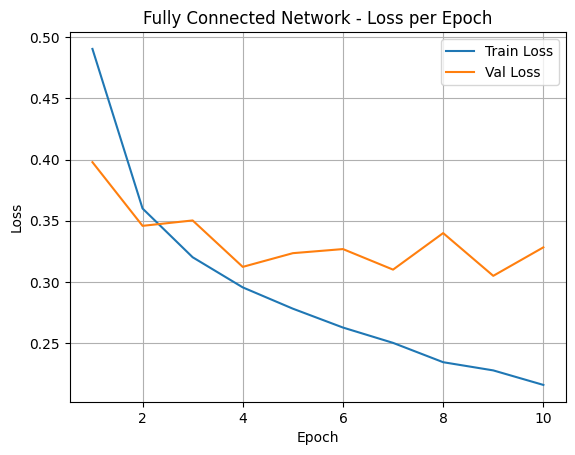

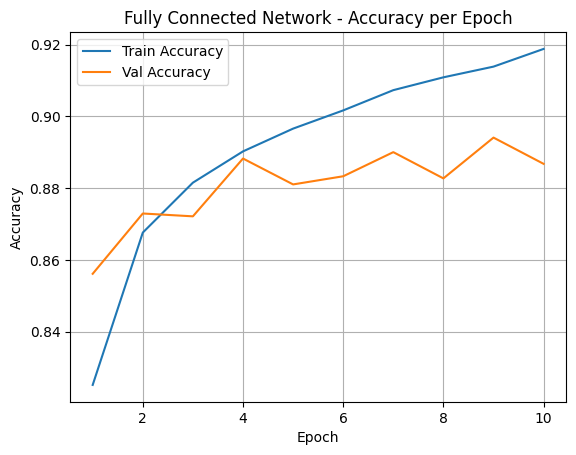

True label: Ankle boot
Predicted class (FC network): Ankle boot
Predicted probabilities: [3.3327925e-07 4.7075066e-08 4.8787111e-08 5.3084523e-08 1.0780888e-08
 1.7745678e-03 9.1994977e-08 1.8005228e-02 3.9955310e-07 9.8021930e-01]


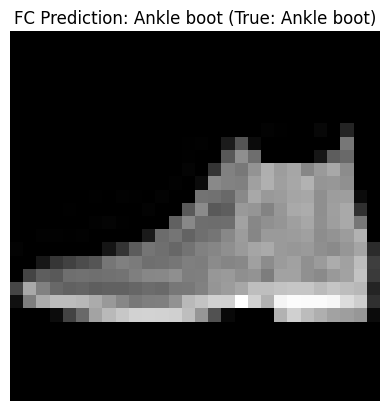

In [ ]:
# 4. Plot FC training/validation curves and show example prediction

epochs_range_fc = range(1, epochs_fc + 1)

class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

plt.figure()
plt.plot(epochs_range_fc, fc_train_loss_history, label="Train Loss")
plt.plot(epochs_range_fc, fc_val_loss_history, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Fully Connected Network - Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(epochs_range_fc, fc_train_acc_history, label="Train Accuracy")
plt.plot(epochs_range_fc, fc_val_acc_history, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Fully Connected Network - Accuracy per Epoch")
plt.legend()
plt.grid(True)
plt.show()

sample_index = 0
sample_image_flat = x_test_flat[sample_index : sample_index + 1]  # shape (1, 784)
sample_image = x_test[sample_index]  # shape (28, 28)
true_label = y_test[sample_index]

probs = fc_model(sample_image_flat, training=False).numpy().squeeze()
predicted_class = np.argmax(probs)

print("True label:", class_names[true_label])
print("Predicted class (FC network):", class_names[predicted_class])
print("Predicted probabilities:", probs)

plt.figure()
plt.imshow(sample_image, cmap="gray")
plt.title(f"FC Prediction: {class_names[predicted_class]} (True: {class_names[true_label]})")
plt.axis("off")
plt.show()
